## Vertebral Column Dataset

The dataset used on this project is hosted in the UCI Machine Learning Repository. It can be downloaded in http://archive.ics.uci.edu/ml/datasets/vertebral+column#.

The main goal is to classify the orthopaedic patients into 3 classes (normal, disk hernia or spondilolysthesis).

After modeling and making the predictions for the test dataset, we are going to make the deployment of the solution using the Streamlit app.



In [1]:
# Importing the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the train dataset.
df=pd.read_csv('/content/column_3C_weka.csv')
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


##  EDA and Data Prepocessing

In [3]:
df.shape

(310, 7)

In [4]:
df['class'].value_counts()

Spondylolisthesis    150
Normal               100
Hernia                60
Name: class, dtype: int64

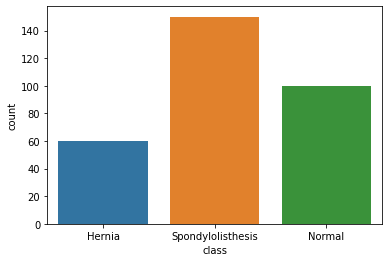

In [5]:
# As we can see, the classes are imbalanced. Patients with hernia represents less than 20% of the dataset and patients with Spondylolisthesis represents almost 50% of it.
sns.countplot(df['class'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


Representing the boxplots of the features in relation to the classes, to analyze the patterns.

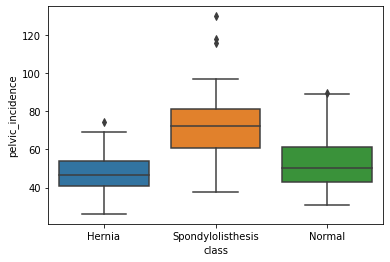

In [7]:
sns.boxplot(x='class', y='pelvic_incidence', data=df)

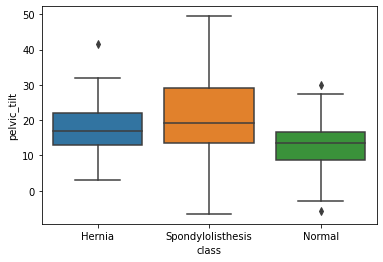

In [8]:
sns.boxplot(x='class', y='pelvic_tilt', data=df)


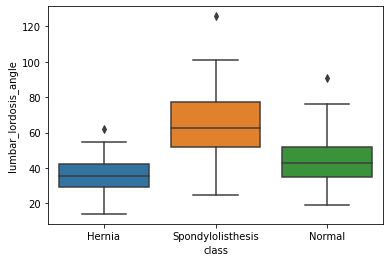

In [9]:
sns.boxplot(x='class', y='lumbar_lordosis_angle', data=df)


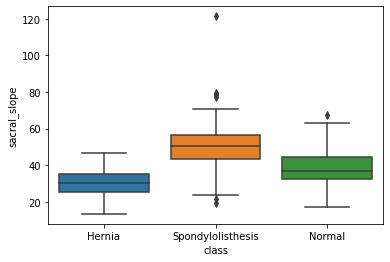

In [10]:
sns.boxplot(x='class', y='sacral_slope', data=df)


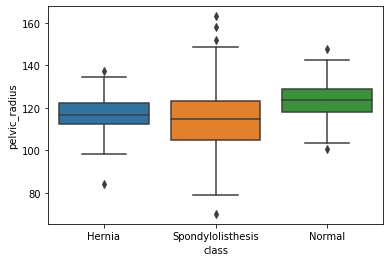

In [11]:
sns.boxplot(x='class', y='pelvic_radius', data=df)


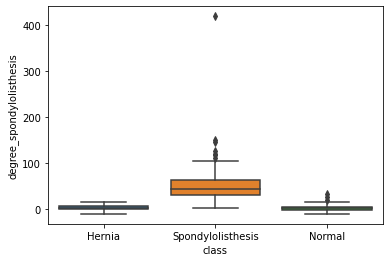

In [12]:
sns.boxplot(x='class', y='degree_spondylolisthesis', data=df)


We see that all the features have higher values for the Spondylolidtheis class.

In [13]:
# There are no missing values on the train dataset. 
df.isnull().sum()

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

In [14]:
# There aren't duplicates in the train dataset.
df.duplicated().sum()

0

Showing de descriptive statistics.

In [15]:
df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [16]:
df.describe(include='object')

,class
count,310
unique,3
top,Spondylolisthesis
freq,150


Let's transform de target in numbers, so we can include it in the pearson correlation analysis.

In [17]:
df['class']=df['class'].map({'Normal':0,'Hernia':1,'Spondylolisthesis':2})

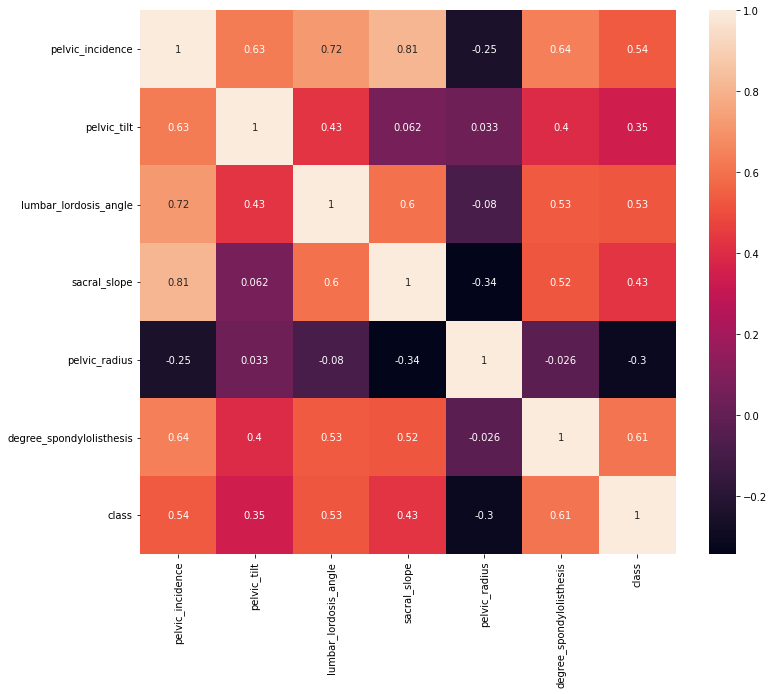

In [18]:
plt.figure (figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

We are going to plot the pairplot, using the 'class' as hue. We can easily see the split in the classes looking at the scatter plots. We can also see how the dataset is imbalanced, we can barely see the hernia examples.

As we can see in the pairplot, the classes can be easily separable, so KNN algorithm can be a good solution for the present problem.

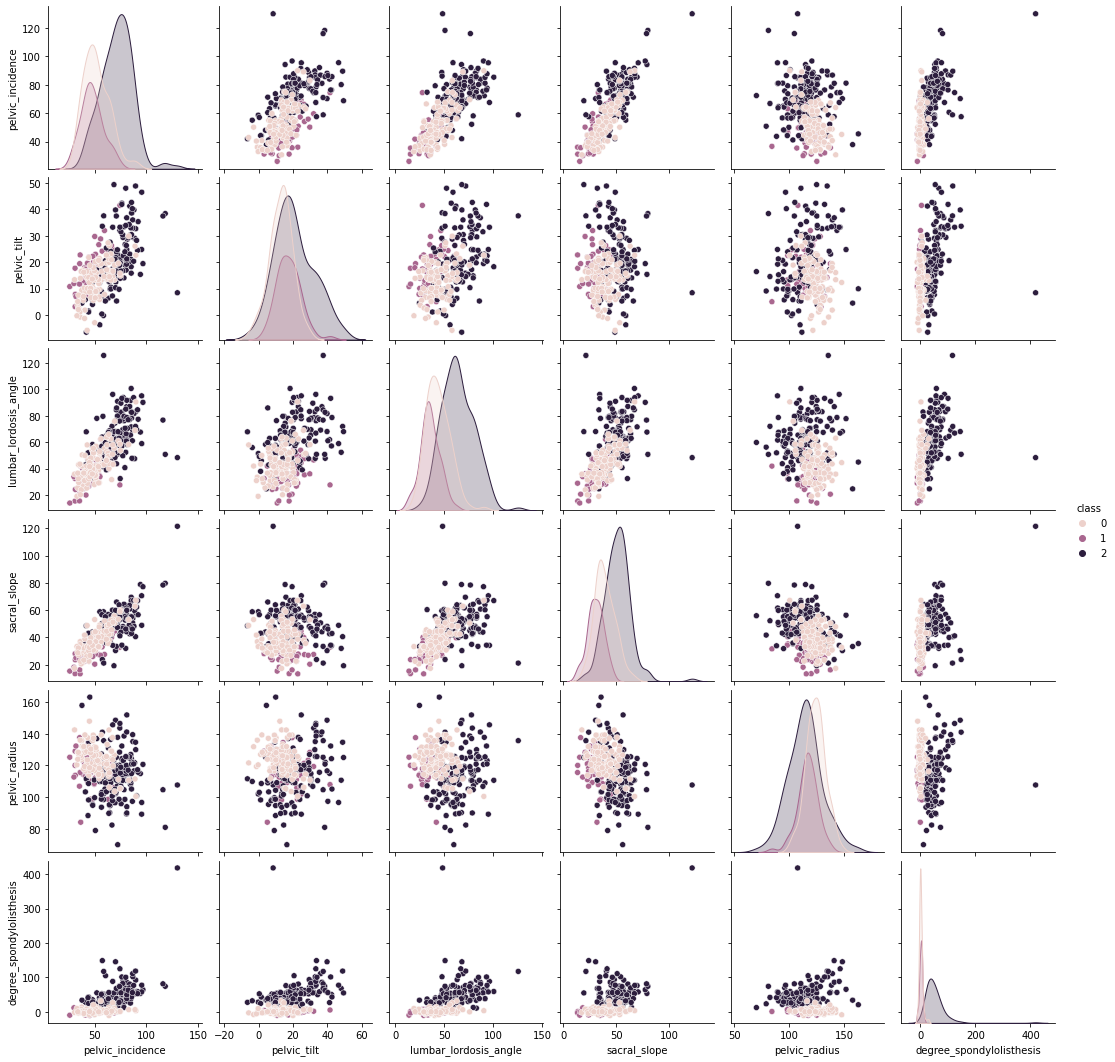

In [19]:
sns.pairplot(df, hue='class')

Let's make the data sampling.

In [20]:
# Splitting the explanatory variables from the target.
y=df['class']
x=df.drop('class', axis=1)

In [21]:
# Splitting the data in training and validation set. I tried to standardizate/ normalize de data but it didn't bring better results.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=0.2, random_state=7)
x_train.shape, x_val.shape

((248, 6), (62, 6))

In [22]:
y_val.value_counts()

2    30
0    20
1    12
Name: class, dtype: int64

Now we are going to oversample the training dataset, using SMOTE. We can't oversample the validation dataset because it would be a case of data leaking, and the evaluation wouldn't be trustworthy.

In [23]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

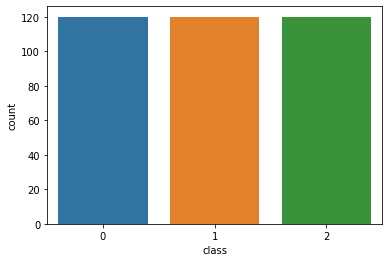

In [24]:
# As we can see in the countplot below, the classes now are balanced.
sns.countplot(y_train)

# Creating and Training the Model

As we saw in the pairplot, the KNN is an algorithm that can be a good solution for the present problem. We could try another models, use hiperparameter tuning with RandomSearch or GridSearch and use cross validation, but the main goal of this project is to show a deploy using streamlit. I decided to stick with an efficient, but simpler model.

In [25]:
# Instantiating the model and fitting with train data.
from sklearn.neighbors import KNeighborsClassifier 
model=KNeighborsClassifier(n_neighbors=3)
model.fit(x_train, y_train)


KNeighborsClassifier(n_neighbors=3)

# Model Evaluation 

As we have a classification problem with imbalanced classes, the accuracy score is not a good metric. We are going to look at f1 score, as it is an harmonic mean between the recall and precision.

Must be highlighted that, as we are talking albout a heath problem, false negatives are more important than false positives, so Recall is better than precision.

In [26]:
prediction=model.predict(x_val)
predictiontrain=model.predict(x_train)

First let's print the classification report from the predictions using the train dataset and the validation dataset.

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_train, predictiontrain)) 

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       120
           1       0.95      0.99      0.97       120
           2       0.98      0.97      0.97       120

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



In [28]:
print(classification_report(y_val, prediction)) 

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.64      0.75      0.69        12
           2       0.97      0.97      0.97        30

    accuracy                           0.84        62
   macro avg       0.80      0.81      0.80        62
weighted avg       0.84      0.84      0.84        62



Let's look at the confusion matrix from the validation dataset.

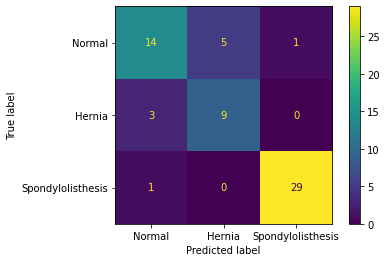

In [29]:
cm=confusion_matrix(y_val, prediction)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Hernia', 'Spondylolisthesis'])
cmd.plot()

The results from de model met the expectations. I'm going to save the model with pickle and then make a deploy using Streamlit app.

In [30]:
import pickle 
pickle_out = open("maquina_preditiva.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()